In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, train_test_split
import scipy.io as sio
from scipy.signal import hamming, butter, lfilter, sosfilt,filtfilt, welch
from scipy.signal import hilbert, coherence
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision
from torch import nn


In [53]:
#Importing the data
datasub2 = sio.loadmat('Long_Words/sub_2b_ch64_l_eog_removed_256Hz.mat')['eeg_data_wrt_task_rep_no_eog_256Hz_last_beep']
datasub3 = sio.loadmat('Long_Words/sub_3b_ch80_l_eog_removed_256Hz.mat')['eeg_data_wrt_task_rep_no_eog_256Hz_last_beep']
datasub6 = sio.loadmat('Long_Words/sub_6_ch64_l_eog_removed_256Hz.mat')['eeg_data_wrt_task_rep_no_eog_256Hz_last_beep']
datasub7 = sio.loadmat('Long_Words/sub_7_ch64_l_eog_removed_256Hz.mat')['eeg_data_wrt_task_rep_no_eog_256Hz_last_beep']
datasub9 = sio.loadmat('Long_Words/sub_9c_ch64_l_eog_removed_256Hz.mat')['eeg_data_wrt_task_rep_no_eog_256Hz_last_beep']
datasub2 = sio.loadmat('Long_Words/sub_11b_ch64_l_eog_removed_256Hz.mat')['eeg_data_wrt_task_rep_no_eog_256Hz_last_beep']

In [54]:
#the function is use to verify if the data is correctly filtered or not.
def verify_filter(eeg_data):
    filter_order = 5
    fs=256
    cutoff_frequency = [8.0,70.0]
    filter_type = 'bandpass'
    b, a = butter(filter_order, cutoff_frequency, filter_type, fs=fs)
    filtered_eeg_data = filtfilt(b, a, eeg_data)
    t = np.arange(len(eeg_data)) / 1000 # create time vector

    #If the filtered EEG data looks similar to what you have already applied, 
    # then you can be confident that a 5th order Butterworth filter has been applied.
    fig, ax = plt.subplots(2, 1, figsize=(10, 6))
    ax[0].plot(t, eeg_data)
    ax[0].set_title('Original EEG data')
    ax[1].plot(t, filtered_eeg_data)
    ax[1].set_title(f'{filter_type.capitalize()} Butterworth filtered EEG data (order = {filter_order}, cutoff = {cutoff_frequency})')
    plt.tight_layout()
    plt.show()
    '''
    f, psd_eeg_data = welch(eeg_data, fs=256)
    f, psd_filtered_eeg_data = welch(filtered_eeg_data, fs=256)
    #The PSD plot should show that the filtered EEG data has reduced power in the frequency range 
    # above the cutoff frequency (for highpass filtering) or below the cutoff frequency (for lowpass filtering) compared to the original EEG data.
    # This indicates that the Butterworth filter has effectively filtered out unwanted frequencies from the EEG data.
    plt.figure()
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.semilogy(f, psd_eeg_data, label='Original EEG data')
    ax.semilogy(f, psd_filtered_eeg_data, label=f'{filter_type.capitalize()} Butterworth filtered EEG data (order = {filter_order}, cutoff = {cutoff_frequency})')
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('PSD (V^2/Hz)')
    ax.set_title('Power Spectral Density')
    ax.legend()
    plt.show()
    '''


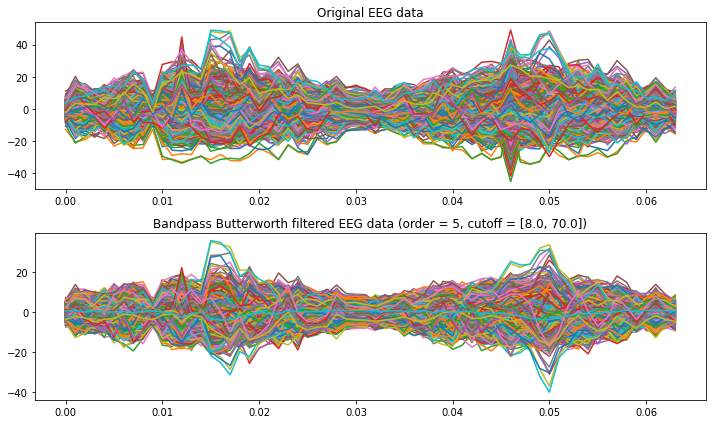

In [55]:
verify_filter(datasub2[0][2])

In [56]:
row, col=datasub2.shape

In [57]:
datasub2[0][0].shape

(64, 1280)

In [58]:
datasub2[0][0].shape

(64, 1280)

In [59]:
# for i in range(row):
#     for j in range(col):
#         datasub2[i][j]=datasub2[i][j][:64,:]

## Data Augmentation and feature extraction

In [60]:
# function for data augmentation
def data_augmentation(data):
    # Find the shape of the data
    n,m=data.shape
    # Initialize the array
    result=np.empty((n,0))
    j=0
    
    # Loop through the data with a stride of 64 samples
    for i in range(0, 1280, 64):
    # Select a window of 256 samples from the data, starting at index i
        window = data[:, i:i+256]
            

        # Replace the original window in the data with the augmented window
        #result.append(window)
        result=np.hstack((result, window))
        

        # Stop the loop if i+256 is greater than or equal to 1280
        if i+256 >= 1280:
            break
    
    
        
    return result

In [61]:
def mean_phase_coherence(signal1, signal2):
  # Compute the analytic signal for each signal using the Hilbert transform
  analytic_signal1 = hilbert(signal1)
  analytic_signal2 = hilbert(signal2)
  # Extract the phase angles of the analytic signals
  angle1 = np.angle(analytic_signal1)
  angle2 = np.angle(analytic_signal2)
  # Calculate the phase coherence between the two phase angles at each time point
  phase_coherences = np.abs(np.exp(1j * (angle1 - angle2)))
  # Return the mean of the phase coherences
  return np.mean(phase_coherences)

In [62]:
#function to extract mpc and msc and create image like structure
def feature_extraction(eeg_data):
    # Number of channels in the EEG data
    num_channels, total_sample=eeg_data.shape

    # Sampling rate of the EEG data (in Hz)
    sampling_rate = 256

    # Cutoff frequencies for the bands (in Hz)
    alpha_cutoff = 13
    beta_cutoff = 30
    gamma_cutoff = 70


    # Length of the window (in samples)
    window_length = 8

    # Overlap between consecutive windows (in samples)
    overlap = window_length - 1

    # Number of segments in each window
    num_segments = 8

    # Generate the Hamming window
    window = hamming(51)
    # Initialize an array to store the Mean Phase Coherence (MPC) values
    mpc = np.zeros((num_channels, num_channels, 3))
    msc = np.zeros((num_channels, num_channels, 3))

    # Split the EEG data into the alpha, beta, and gamma bands for each channel
    alpha_bands = []
    beta_bands = []
    gamma_bands = []
    for i in range(num_channels):
            a = butter(10, [8, 13], 'bandpass', fs=256, output='sos')
            b = butter(10, [13, 30], 'bandpass', fs=256, output='sos')
            g = butter(10, [30, 70], 'bandpass', fs=256, output='sos')

            alpha_bands = sosfilt(a, eeg_data, axis = 1)
            beta_bands = sosfilt(b, eeg_data, axis = 1)
            gamma_bands = sosfilt(g, eeg_data, axis = 1)
    
    # Loop over all pairs of channels
    for i in range(num_channels):
        for j in range(i+1, num_channels):
        # Calculate the MPC between the two channels in the alpha band
            mpc[i, j, 0] = np.abs(np.mean(np.exp(1j*(np.angle(hilbert(alpha_bands[i])) - np.angle(hilbert(alpha_bands[j]))))))
            #mpc[i,j,0]=mean_phase_coherence(alpha_bands[i], alpha_bands[j])
            # Calculate the MPC between the two channels in the beta band
            mpc[i, j, 1] =np.abs(np.mean(np.exp(1j*(np.angle(hilbert(beta_bands[i])) - np.angle(hilbert(beta_bands[j]))))))
            #mpc[i,j,1]=mean_phase_coherence(beta_bands[i], beta_bands[j])
            # Calculate the MPC between the two channels in the gamma band
            mpc[i, j, 2] = np.abs(np.mean(np.exp(1j*(np.angle(hilbert(gamma_bands[i])) - np.angle(hilbert(gamma_bands[j]))))))
            #mpc[i,j,2]=mean_phase_coherence(gamma_bands[i],gamma_bands[j])
    
            # Calculate the MSC between the two channels in the alpha band
            temp=coherence(eeg_data[i], eeg_data[j],window=window , nfft = 256, fs=256)
            t1 = (temp[0] <= 8).astype(bool)
            t2 = (temp[0] <= 13).astype(bool)
            t3 = (temp[0] <= 30).astype(bool)
            t4 = (temp[0] <= 70).astype(bool)
            alpha = np.mean(temp[1][~t1 & t2])
            beta = np.mean(temp[1][~t2 & t3])
            gamma = np.mean(temp[1][~t3 & t4])
            msc[i,j,0] = alpha
            msc[i,j,1] = beta
            msc[i,j,2] = gamma
            # alpha_msc = Cxy[(f >= 8) & (f <= alpha_cutoff)]
           
            # msc[i,j,0]=np.mean(alpha_msc)

            # beta_msc = Cxy[(f >= alpha_cutoff) & (f <= beta_cutoff)]
            # msc[i,j,1]=np.mean(beta_msc)
            # gamma_msc = Cxy[(f >= beta_cutoff) & (f <= gamma_cutoff)]
            # msc[i,j,2]=np.mean(gamma_msc)

    #Transposing the mpc matrix so to add with mpc
    msc[:,:,0]=msc[:,:,0].T
    msc[:,:,1]=msc[:,:,1].T
    msc[:,:,2]=msc[:,:,2].T
    

  
    plt.imshow(msc[:,:,1],aspect=1)

    
    #creating the final matrix contaning the mpc and msc values
    feature=msc+mpc
    
    return feature

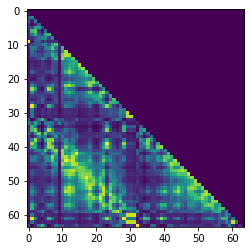

In [63]:
feature=feature_extraction(datasub2[0][0])

In [64]:
feature[:,:,1]

array([[0.        , 0.15988915, 0.42160216, ..., 0.16488831, 0.16231554,
        0.42178329],
       [0.06343071, 0.        , 0.54857493, ..., 0.95475173, 0.46924809,
        0.1855013 ],
       [0.2553817 , 0.45149948, 0.        , ..., 0.52087192, 0.26915847,
        0.2644642 ],
       ...,
       [0.06147292, 0.96663852, 0.43233515, ..., 0.        , 0.45330434,
        0.17096972],
       [0.04608243, 0.37199596, 0.11020637, ..., 0.37234338, 0.        ,
        0.35285629],
       [0.2343407 , 0.02250222, 0.10954823, ..., 0.02497362, 0.1173523 ,
        0.        ]])

In [65]:
# function to extract feature with data Augmentation. 
def Augmentation_feature(data):
    # find the dimension
    n=len(data)
    m=len(data[0])
    #iterating over words

    feature= np.empty((n, m),dtype=object)  
    for i in range(n):
        #iterating over trials
        for j in range(m):
            # applying the data augmentation function
            window=data_augmentation(data[i][j])
            #assigning the augmented data
            #data[i][j]=window
            #Extracting the features
            feature[i][j]=feature_extraction(window)

            


    return feature

In [66]:
#Function to extract feature for test data.
def Only_feature(data):
    # find the dimension
    n=len(data)
    m=len(data[0])
    #iterating over words

    feature= np.empty((n, m),dtype=object)  
    for i in range(n):
        #iterating over trials
        for j in range(m):
            # applying the data augmentation function
            # window=data_augmentation(data[i][j])
            #assigning the augmented data
            #data[i][j]=window
            #Extracting the features
            feature[i][j]=feature_extraction(data[i][j])

            


    return feature

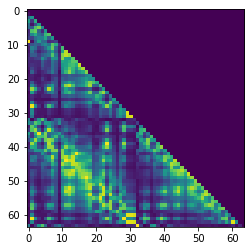

In [67]:
#extracting features with augmentation(for trainning data)
trainsub2 =Augmentation_feature(datasub2)
np.save("Long_Words/trainsub2", trainsub2,allow_pickle=True)


In [68]:
#load data for trainning
trainsub2=np.load("Long_Words/trainsub2.npy",allow_pickle=True)

In [69]:
trainsub2.shape

(2, 100)

In [70]:
trainsub2[0][0]

array([[[0.        , 0.        , 0.        ],
        [0.51987587, 0.17889386, 0.38512729],
        [0.62764411, 0.4248368 , 0.52562107],
        ...,
        [0.56309055, 0.18024718, 0.379903  ],
        [0.42676648, 0.15155905, 0.40716669],
        [0.38899837, 0.40576875, 0.50145839]],

       [[0.27269146, 0.06770633, 0.24534748],
        [0.        , 0.        , 0.        ],
        [0.65841325, 0.55765746, 0.52802099],
        ...,
        [0.97050531, 0.9595118 , 0.88786481],
        [0.75933004, 0.47960063, 0.66605104],
        [0.53846083, 0.15553161, 0.40690925]],

       [[0.36715325, 0.25295667, 0.36872821],
        [0.66968072, 0.44639008, 0.46699286],
        [0.        , 0.        , 0.        ],
        ...,
        [0.68293511, 0.52955921, 0.48369895],
        [0.52353634, 0.27316753, 0.377071  ],
        [0.44971926, 0.25559068, 0.40586103]],

       ...,

       [[0.28539167, 0.06266867, 0.25694142],
        [0.98349106, 0.96655775, 0.89981755],
        [0.65869538, 0

In [71]:
trainsub2[0][0]

array([[[0.        , 0.        , 0.        ],
        [0.51987587, 0.17889386, 0.38512729],
        [0.62764411, 0.4248368 , 0.52562107],
        ...,
        [0.56309055, 0.18024718, 0.379903  ],
        [0.42676648, 0.15155905, 0.40716669],
        [0.38899837, 0.40576875, 0.50145839]],

       [[0.27269146, 0.06770633, 0.24534748],
        [0.        , 0.        , 0.        ],
        [0.65841325, 0.55765746, 0.52802099],
        ...,
        [0.97050531, 0.9595118 , 0.88786481],
        [0.75933004, 0.47960063, 0.66605104],
        [0.53846083, 0.15553161, 0.40690925]],

       [[0.36715325, 0.25295667, 0.36872821],
        [0.66968072, 0.44639008, 0.46699286],
        [0.        , 0.        , 0.        ],
        ...,
        [0.68293511, 0.52955921, 0.48369895],
        [0.52353634, 0.27316753, 0.377071  ],
        [0.44971926, 0.25559068, 0.40586103]],

       ...,

       [[0.28539167, 0.06266867, 0.25694142],
        [0.98349106, 0.96655775, 0.89981755],
        [0.65869538, 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


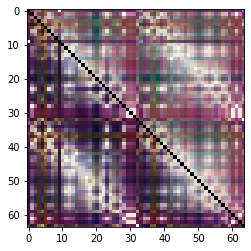

In [72]:
from PIL import Image
plt.imshow(trainsub2[0][0],aspect=1)

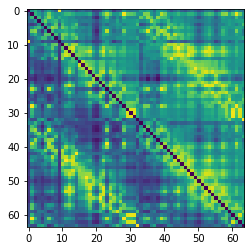

In [73]:
from PIL import Image
plt.imshow(trainsub2[0][0][:,:,0],aspect=1)


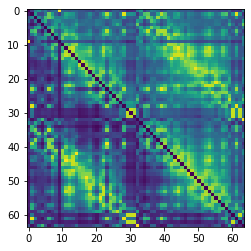

In [74]:
from PIL import Image
plt.imshow(trainsub2[0][0][:,:,1],aspect=1)

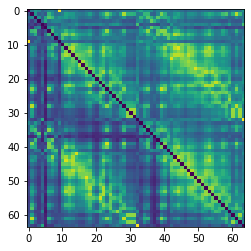

In [75]:
from PIL import Image
plt.imshow(trainsub2[0][0][:,:,2],aspect=1)

In [76]:
#extract feature for test data and store.
testsub2=Only_feature(datasub2)
np.save("Long_Words/testsub2",testsub2,allow_pickle=True)

In [ ]:
#load test feature.
testsub2=np.load("Long_Words/testsub2.npy", allow_pickle=True)

In [ ]:
testsub2[0][0].shape

(64, 64, 3)

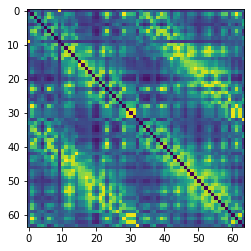

In [ ]:
from PIL import Image
plt.imshow(testsub2[0][0][:,:,0],aspect=1)

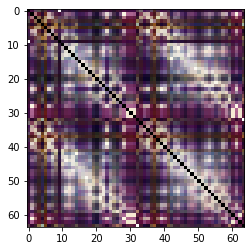

In [ ]:
from PIL import Image
plt.imshow(testsub2[0][0],aspect=1)

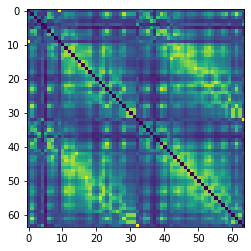

In [ ]:
from PIL import Image
plt.imshow(testsub2[0][0][:,:,2],aspect=1)

# Create a Neural Network model

In [ ]:
# Number of classes and trails in the subject's data
num_classes = 2
num_trails = 100

In [ ]:
label=np.zeros(( num_classes, num_trails))
label[1,:]=1

In [ ]:
label.shape

(2, 100)

In [ ]:
def calculate_accuracy(model, X, y):
    # Make predictions
    logits = model(X)
    
    _, predictions = torch.max(logits, dim=1)
    
    
    # Calculate the number of correct predictions
    correct_predictions = torch.sum(predictions == y).item()
    
    # Calculate the accuracy
    accuracy = correct_predictions / len(y)
    
    return accuracy

In [ ]:
class ImaginedDataset(Dataset):
    def __init__(self, img_labels, images, transform=None, target_transform=None):
        self.img_labels = img_labels
        self.images = images
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        
        image =(self.images[idx]).astype(float).transpose(2,0,1)
        label = torch.tensor(self.img_labels[idx])
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [ ]:
label[0].shape

(100,)

In [ ]:
import copy

In [ ]:
class model_maker(nn.Module):
    def __init__(self, num_classes=None):
        super(model_maker, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()) # 64*64*64
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size = 2, stride = 2)) #32*32*64
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)) #16*16*128
        self.layer5 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer6 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer7 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)) #8*8*256
        self.layer8 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer9 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer10 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        # self.layer11 = nn.Sequential(
        #     nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
        #     nn.BatchNorm2d(512),
        #     nn.ReLU())
        # self.layer12 = nn.Sequential(
        #     nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
        #     nn.BatchNorm2d(512),
        #     nn.ReLU())
        # self.layer13 = nn.Sequential(
        #     nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
        #     nn.BatchNorm2d(512),
        #     nn.ReLU(),
        #     nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.fc = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(4*4*512, 4096),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(4096, 512),
            nn.ReLU())
        self.fc2 = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(512, 128),
            nn.ReLU())
        self.fc3= nn.Sequential(
            nn.Linear(128, num_classes))
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.layer7(out)
        out = self.layer8(out)
        out = self.layer9(out)
        out = self.layer10(out)
        # out = self.layer11(out)
        # out = self.layer12(out)
        # out = self.layer13(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out

In [ ]:



# Initialize a KFold object with 10 folds
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

#assigning device
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device=torch.device("cuda:1")
# Loop over the folds
k=0
for train_index, test_index in kfold.split(datasub2[0],label[0]):
    print("*****************")
    print(f"Looping over the fold: {k}")


    # Number of classes and trails in the subject's data
    num_classes = 2
    num_trails = 100

    '''
    # Load the pretrained ResNet-50 model
    model = torchvision.models.resnet50(weights="ResNet50_Weights.DEFAULT")

    # Freeze the layers of the ResNet model
    for param in model.parameters():
        param.requires_grad = False

    # Remove the fully connected layer
    num_ftrs = model.fc.in_features
    model.fc = nn.Sequential()

    # Add your own fully connected layers
    model.fc.add_module('fc1', nn.Linear(num_ftrs, 128))
    model.fc.add_module('relu1', nn.ReLU())
    #model.fc.add_module("Dropout1", nn.Dropout(0.3))
    model.fc.add_module('fc2', nn.Linear(128, 64))
    model.fc.add_module('relu2', nn.ReLU())
    # model.fc.add_module('fc2', nn.Linear(128, 32))
    # model.fc.add_module('relu2', nn.ReLU())
    #model.fc.add_module('dropout2', nn.Dropout(0.3))
    model.fc.add_module('fc3', nn.Linear(64, num_classes))
    '''
    model=model_maker(num_classes)
    

    # Set the requires_grad attribute of the fully connected layers to True
    for param in model.fc.parameters():
        param.requires_grad = True

    # Define a loss function and an optimizer
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

    # Get the training and testing data for this fold
    train_X=trainsub2[:,train_index]
    train_X=train_X.T
    train_y=label[:,train_index]
    train_y=train_y.T
    X_test=testsub2[:,test_index]
    y_test=label[:,test_index]

    X_train, X_val, y_train, y_val = train_test_split(train_X, train_y, test_size=0.20,  random_state=42)
    X_train=X_train.reshape((-1,))
    y_train=y_train.reshape((-1,))
    X_val=X_val.reshape((-1,))
    y_val=y_val.reshape((-1,))
    X_test=X_test.reshape((-1,))
    y_test=y_test.reshape((-1,))
    train_dataset=ImaginedDataset(y_train,X_train)
    val_dataset=ImaginedDataset(y_val, X_val)
    test_dataset=ImaginedDataset(y_test, X_train)
    train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)

  
    '''
    X_train=X_train.transpose((1,0,4,2,3))
    X_val=X_val.transpose((1,0,4,2,3))
    y_train=y_train.T
    y_val=y_val.T
    X_test=X_test.transpose((0,1,4,2,3))

    X_train=X_train.reshape((-1,3,64,64))
    y_train=y_train.reshape((-1,))
    
    X_val=X_val.reshape((-1,3,64,64))
    y_val=y_val.reshape((-1,))

    X_test=X_test.reshape((-1,3,64,64))
    y_test=y_test.reshape((-1,))

    # Convert the data to tensors
    X_train = torch.tensor(X_train, dtype=torch.float32, device=device)
    y_train = torch.tensor(y_train, dtype=torch.long, device=device)
    X_val = torch.tensor(X_val, dtype=torch.float32, device=device)
    y_val = torch.tensor(y_val, dtype=torch.long, device=device)
    X_test = torch.tensor(X_test, dtype=torch.float32, device=device)
    y_test = torch.tensor(y_test, dtype=torch.long, device=device)
    '''
    
    
    model.to(device)

    best_model_wts = copy.deepcopy(model.state_dict())
    # Set the patience parameter
    patience = 30
    temp_patience=patience
    # Set the total number of epochs
    num_epochs = 150

    # Initialize the best validation loss
    best_val_loss = float('inf')
    best_val_acc=0
    best_epoch=0
    best_loss = 1


    # Initialize the early stopping counter
    early_stopping_counter = 0
    
    # Train the model for the specified number of epochs
    for epoch in range(num_epochs):
        # Initialize the training loss and accuracy for this epoch
        train_loss = 0.0
        train_acc = 0.0
        
        # Train the model on the training set
        model.train()
        for images, labels in train_dataloader:
            images=images.to(device,dtype=torch.float)
            labels=labels.type(torch.LongTensor)
            labels=labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            _, predicted = outputs.max(dim=1)
            train_acc += (predicted == labels).sum().item()
        training_acc = train_acc / len(train_dataloader.dataset)
        training_loss = train_loss / len(train_dataloader.dataset)
        
        # Evaluate the model on the validation set
        model.eval()
        with torch.no_grad():
            val_loss = 0.0
            val_acc = 0.0
            for images, labels in val_dataloader:
                
                images=images.to(device,dtype=torch.float)
                labels=labels.type(torch.LongTensor)
                labels=labels.to(device)
                outputs = model(images)
                loss = loss_fn(outputs, labels)
                val_loss += loss.item()
                _, predicted = outputs.max(dim=1)
                val_acc += (predicted == labels).sum().item()
            validation_acc = val_acc / len(val_dataloader.dataset)
            validation_loss = val_loss / len(val_dataloader.dataset)

        
            if epoch % 5 == 0 or epoch == (num_epochs - 1):
                print(f'\t epoch:{epoch}, T.acc:{training_acc*100:.3f}, V.acc:{validation_acc*100:.3f}')
                print(f'\t\t T.loss:{training_loss:.5f}, V.loss:{validation_loss:.5f}')


            if validation_loss > best_loss :
                patience -= 1
                if patience <= 0:
                    print('Early stopping :(')
                    print(f'\t epoch:{epoch}, T.acc:{training_acc*100:.3f}, V.acc:{validation_acc*100:.3f}')
                    print(f'\t\t T.loss:{training_loss:.5f}, V.loss:{validation_loss:.5f}')
                    break
            else:
                best_loss = validation_loss
                patience = temp_patience
                best_model_wts = copy.deepcopy(model.state_dict())
        
        # if epoch%30==0:
        
        #     # Print the training and validation loss and accuracy for this epoch
        #     print(f"Epoch: {epoch+1}")
        #     print(f' Train loss: {train_loss:.4f} Train acc: {train_acc/len(train_dataloader.dataset):.4f}')
        #     print(f" Validation loss: {val_loss:.4f} Validation acc: {val_acc/len(val_dataloader.dataset):.4f}")
        
        # # Check if the validation loss has improved
        # if val_loss < best_val_loss:
        #     best_val_loss = val_loss
        #     best_val_acc=val_acc
        #     best_epoch=epoch
        #     early_stopping_counter = 0
        # else:
        #     early_stopping_counter += 1
        
        # # If the early stopping counter has reached the patience threshold, stop training
        # if early_stopping_counter == patience:
        #     print(f'Early stopping at epoch {epoch+1}')

        #     #Print the training and validation loss and accuracy for this epoch
        #     print(f' Train loss: {train_loss:.4f} Train acc: {train_acc/len(train_dataloader.dataset):.4f}')
        #     print(f" Validation loss: {val_loss:.4f} Validation acc: {val_acc/len(val_dataloader.dataset):.4f}")
        #     print(f" Best Validation loss: {best_val_loss:.4f} Best Validation acc: {best_val_acc/len(val_dataloader.dataset):.4f} Best Epoch:{best_epoch}")
        #     break
    model.load_state_dict(best_model_wts)


    # Test the model on the test set
    model.eval()
    print("****testing*****")
    with torch.no_grad():
        test_loss = 0.0
        test_acc = 0.0
        for images, labels in test_dataloader:
            images=images.to(device,dtype=torch.float)
            labels=labels.type(torch.LongTensor)
            labels=labels.to(device)
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            test_loss += loss.item()
            _, predicted = outputs.max(dim=1)
            test_acc += (predicted == labels).sum().item()
        total_loss = test_loss / len(test_dataloader.dataset)
        accuracy = test_acc / len(test_dataloader.dataset)
        print(f" Test loss: {total_loss:.4f} Test acc: {accuracy*100:.3f}")
    k+=1


*****************
Looping over the fold: 0
	 epoch:0, T.acc:47.222, V.acc:50.000
		 T.loss:0.01456, V.loss:0.01926
	 epoch:5, T.acc:69.444, V.acc:50.000
		 T.loss:0.01403, V.loss:0.01926
	 epoch:10, T.acc:84.722, V.acc:50.000
		 T.loss:0.01315, V.loss:0.01929
	 epoch:15, T.acc:90.278, V.acc:50.000
		 T.loss:0.01140, V.loss:0.01948
	 epoch:20, T.acc:96.528, V.acc:47.222
		 T.loss:0.00968, V.loss:0.02006
	 epoch:25, T.acc:98.611, V.acc:47.222
		 T.loss:0.00658, V.loss:0.02158
	 epoch:30, T.acc:100.000, V.acc:44.444
		 T.loss:0.00330, V.loss:0.02234
	 epoch:35, T.acc:100.000, V.acc:47.222
		 T.loss:0.00195, V.loss:0.02387
Early stopping :(
	 epoch:37, T.acc:100.000, V.acc:38.889
		 T.loss:0.00127, V.loss:0.02414
****testing*****
 Test loss: 0.0346 Test acc: 55.000
*****************
Looping over the fold: 1
	 epoch:0, T.acc:54.167, V.acc:50.000
		 T.loss:0.01457, V.loss:0.01926
	 epoch:5, T.acc:59.028, V.acc:50.000
		 T.loss:0.01412, V.loss:0.01926
	 epoch:10, T.acc:81.250, V.acc:50.000
		